In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
import time
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
import sys
sys.path.append('../config')
from model_config import ModelConfig

2024-11-24 23:00:42.872604: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
import time
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.append('../config')
from model_config import ModelConfig

def predict_bitcoin_prices(start_date, end_date):
    """
    Predict Bitcoin prices for a specified date range using LSTM model.
    
    Args:
        start_date (str): Start date in format 'YYYY-MM-DD'
        end_date (str): End date in format 'YYYY-MM-DD'
    
    Returns:
        dict: Dictionary containing:
            - mae (float): Mean Absolute Error
            - mape (float): Mean Absolute Percentage Error
            - runtime (int): Prediction runtime in milliseconds
            - pred_list (list): List of predicted prices
            - actual_prices (list): List of actual prices
    """
    
    def fetch_crypto_data(start_date, end_date):
        """
        Fetch Bitcoin price data from CryptoCompare API
        """
        # Convert dates to timestamps
        start_ts = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp())
        end_ts = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())
        
        # Calculate number of days
        days = (end_ts - start_ts) // 86400 + 1
        
        # Add extra days for sequence creation
        padded_start_ts = start_ts - (ModelConfig.TIME_STEPS * 86400)
        
        # CryptoCompare API endpoint
        url = "https://min-api.cryptocompare.com/data/v2/histoday"
        params = {
            "fsym": "BTC",
            "tsym": "USD",
            "limit": days + ModelConfig.TIME_STEPS,
            "toTs": end_ts
        }
        
        response = requests.get(url, params=params)
        data = response.json()
        
        if data['Response'] != 'Success':
            raise Exception("Failed to fetch data from CryptoCompare API")
            
        # Create DataFrame
        df = pd.DataFrame(data['Data']['Data'])
        df['date'] = pd.to_datetime(df['time'], unit='s')
        df = df.rename(columns={
            'open': 'Open',
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
            'volumefrom': 'Volume'
        })
        
        return df
    
    try:
        # Load model
        model = load_model('../models/lstm_model.keras')
        
        # Fetch data
        df = fetch_crypto_data(start_date, end_date)
        
        # Add placeholder sentiment data
        df['sentiment_scores'] = 0.5  # placeholder value
        df['is_real_sentiment'] = False
        
        # Prepare features
        features = ['Open', 'Volume', 'sentiment_scores', 'is_real_sentiment']
        X = df[features]
        y = df['Close']
        
        # Create new scalers for this specific date range
        scaler_X_new = MinMaxScaler()
        scaler_y_new = MinMaxScaler()
        
        # Fit and transform the data
        X_normalized = pd.DataFrame(
            scaler_X_new.fit_transform(X),
            columns=X.columns,
            index=X.index
        )
        y_normalized = pd.DataFrame(
            scaler_y_new.fit_transform(y.values.reshape(-1, 1)),
            columns=['Close'],
            index=y.index
        )
        
        # Create sequences
        def create_sequences(X, y, time_steps=ModelConfig.TIME_STEPS):
            Xs, ys = [], []
            for i in range(len(X) - time_steps):
                Xs.append(X.iloc[i:(i + time_steps)].values)
                ys.append(y.iloc[i + time_steps])
            return np.array(Xs), np.array(ys)
        
        X_seq, y_seq = create_sequences(X_normalized, y_normalized)
        
        # Make predictions and measure runtime
        start_time = time.time()
        y_pred_normalized = model.predict(X_seq, verbose=0)
        end_time = time.time()
        prediction_runtime = int((end_time - start_time) * 1000)  # Convert to milliseconds
        
        # Inverse transform predictions
        y_pred = scaler_y_new.inverse_transform(y_pred_normalized)
        y_actual = y.iloc[ModelConfig.TIME_STEPS:].values
        
        # Calculate metrics
        mae = mean_absolute_error(y_actual, y_pred)
        mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
        
        # Plotting the results
        plt.figure(figsize=(15, 7))
        plt.plot(df['date'][ModelConfig.TIME_STEPS:], y_actual, 
                label='Actual Price', color='blue', alpha=0.7)
        plt.plot(df['date'][ModelConfig.TIME_STEPS:], y_pred, 
                label='Predicted Price', color='red', alpha=0.7)
        plt.title('Bitcoin Price: Actual vs Predicted')
        plt.xlabel('Date')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return {
            'mae': float(mae),
            'mape': float(mape),
            'runtime': prediction_runtime,
            'pred_list': y_pred.flatten().tolist(),
            'actual_prices': y_actual.flatten().tolist()
        }
        
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None

# Example usage:
# results = predict_bitcoin_prices('2024-10-01', '2024-10-31')
# print(f"MAE: ${results['mae']:.2f}")
# print(f"MAPE: {results['mape']:.2f}%")
# print(f"Runtime: {results['runtime']} ms")
# print(f"Number of predictions: {len(results['pred_list'])}")

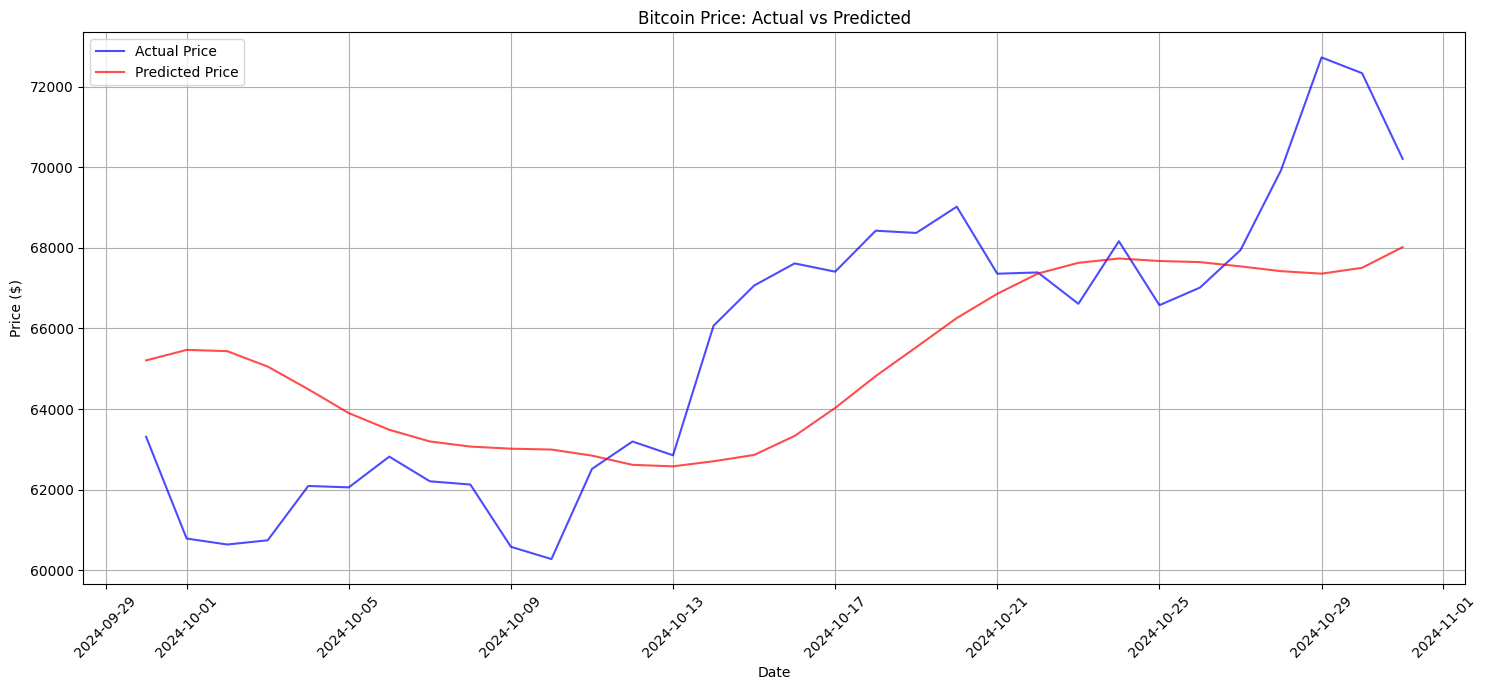

MAE: $2257.98
MAPE: 5.10%
Runtime: 1180 ms
Number of predictions: 32


In [4]:
# Example usage:
results = predict_bitcoin_prices('2024-10-01', '2024-10-31')
print(f"MAE: ${results['mae']:.2f}")
print(f"MAPE: {results['mape']:.2f}%")
print(f"Runtime: {results['runtime']} ms")
print(f"Number of predictions: {len(results['pred_list'])}")